In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
from scipy import ndimage
#import statistics as stat
import random
import scipy 
#import copy
#from scipy import integrate
from dask.distributed import Client, progress, wait

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45708 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 10.74 GB


In [3]:
#Constants
g = 9.8
MWa = 0.02897 # kg mol-1
MWw = 0.01802 #kg mol-1
#for relative humidity and saturation deficit
eps = 0.01802/0.02897
rho = 1000 

### Loading data into Notebook

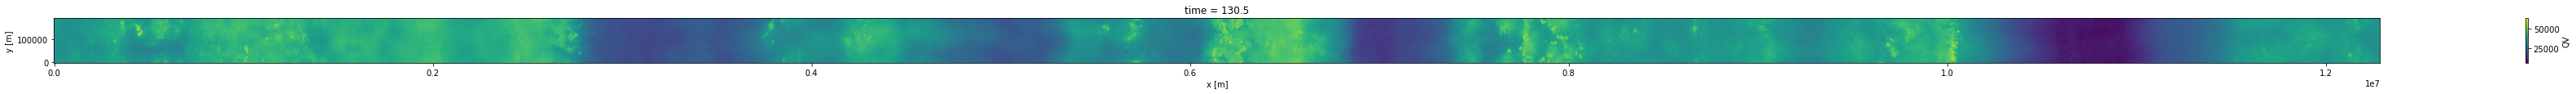

In [4]:
path = '/work/bb1018/b380873/RCE-CAPE-exploration/RCE-sims/ch_cam300ri0/'

ds = xr.open_mfdataset(path+'ch_cam300ri0_4096x64x64_3km_12s_cam300ri0_64_*.nc',combine='by_coords')

cwvc_ = ds.QV.integrate('z')

cwvc_.isel(time=199).plot(figsize=(64,1))


In [5]:
ds.p.isel(time=199).values

array([1007.748,  999.172,  989.853,  979.248,  967.279,  953.432,
        937.336,  918.335,  895.119,  867.265,  833.791,  795.875,
        755.132,  713.107,  671.385,  631.136,  592.869,  556.5  ,
        521.955,  489.164,  458.06 ,  428.574,  400.617,  374.102,
        348.958,  325.123,  302.538,  281.149,  260.907,  241.771,
        223.701,  206.663,  190.626,  175.565,  161.455,  148.271,
        135.994,  124.617,  114.141,  104.541,   95.78 ,   87.794,
         80.51 ,   73.873,   67.831,   62.323,   57.298,   52.715,
         48.524,   44.691,   41.182,   37.968,   35.019,   32.309,
         29.819,   27.525,   25.405,   23.446,   21.636,   19.965,
         18.414,   16.962,   15.61 ,   14.362], dtype=float32)

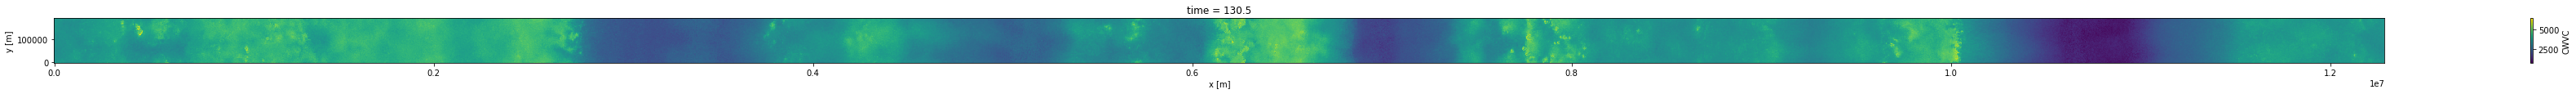

In [6]:
xr_clust = xr.open_dataset('combined_clust_sst300.nc')

xr_clust.CWVC.isel(time=199).plot(figsize=(64,1))

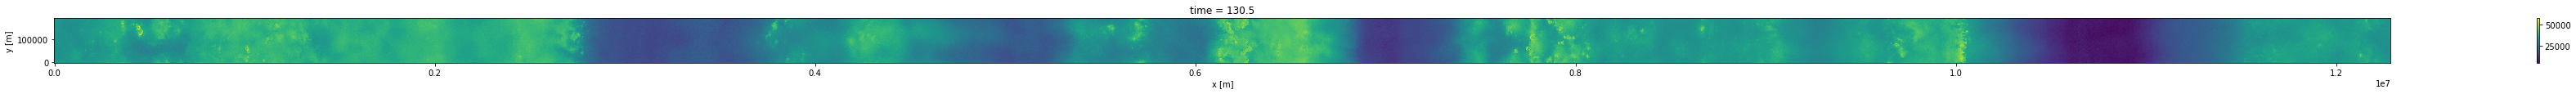

In [7]:
#### Below is producing inconsistent results

(cwvc_ - xr_clust.CWVC).isel(time=199).plot(figsize=(64,1))

In [8]:
#calling the surface (z=0) level values
psurf = ds.QP.isel(z=0)

psurf

<xarray.DataArray 'QP' (time: 400, y: 64, x: 4096)>
dask.array<getitem, shape=(400, 64, 4096), dtype=float32, chunksize=(1, 64, 4096), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 0.0 3e+03 6e+03 9e+03 ... 1.228e+07 1.228e+07 1.228e+07
  * y        (y) float32 0.0 3e+03 6e+03 9e+03 ... 1.83e+05 1.86e+05 1.89e+05
    z        float32 37.0
  * time     (time) float64 80.75 81.0 81.25 81.5 ... 179.8 180.0 180.2 180.5
Attributes:
    long_name:  Precipitating Water (Rain+Snow)                              ...
    units:      g/kg

In [9]:
ds_t199 = ds.isel(time=199)

qn_245 = ds.QN.where(ds.TABS<245)

qn_245 = qn_245.bfill('z').isel(z=0)

mcs_xr = xr.where(qn_245<10**(-4),0,1)

mcs_xr

<xarray.DataArray 'QN' (time: 400, y: 64, x: 4096)>
dask.array<where, shape=(400, 64, 4096), dtype=int64, chunksize=(1, 64, 4096), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 0.0 3e+03 6e+03 9e+03 ... 1.228e+07 1.228e+07 1.228e+07
  * y        (y) float32 0.0 3e+03 6e+03 9e+03 ... 1.83e+05 1.86e+05 1.89e+05
    z        float32 37.0
  * time     (time) float64 80.75 81.0 81.25 81.5 ... 179.8 180.0 180.2 180.5

In [10]:
def storm_labeller(binary_t_xr):
    
    #print(binary_t_xr)
    
    struct = np.zeros((3,3,3))

    struct[1] = [[0,1,0],[1,1,1],[0,1,0]]

    
    labels_0,nb_0 = ndimage.label(binary_t_xr,structure=struct)
    
    print(labels_0.shape)
    
    #time=binary_t_xr.time
    
    
    #find the sizes of each object, in terms of pixels 
    pixelsizes = ndimage.sum(binary_t_xr,labels_0,range(nb_0+1))

    #create a boolean array for whether the objects 
    #are larger than a given threshold
    mask_size = pixelsizes < 310

    #indices of pixels to be removed are produced
    remove_pixel = mask_size[labels_0]
  
    #indices and thus objects are removed based on object size
    labels_0[remove_pixel] = 0

    labelled_xr = xr.DataArray(labels_0,
                               dims=['time','y','x'],
                               coords={'time':binary_t_xr.time,'y':binary_t_xr.y,
                                       'x':binary_t_xr.x})
    
    return labelled_xr

"""
def storm_labeller_3d(binary_xr_3d):
    
    empty_3d = np.empty((400,64,4096))
    
    for i in np.arange(400):

        empty_3d[i] = storm_labeller(binary_xr_3d.isel(time=i))
        
    labelled_xr = xr.DataArray(empty_3d,
                               dims=['time','y','x'],
                               coords={'time':binary_xr_3d.time.isel(time=slice(199,203)),
                                       'y':binary_xr_3d.y.values,
                                       'x':binary_xr_3d.x.values})
    
    return labelled_xr.rename('Clusters')
        

#clusters = storm_labeller_3d(mcs_xr).compute()
"""

storms_alltime = storm_labeller(mcs_xr)

(400, 64, 4096)


## New connected components structure allows ndimage application to whole time,x,y dataset

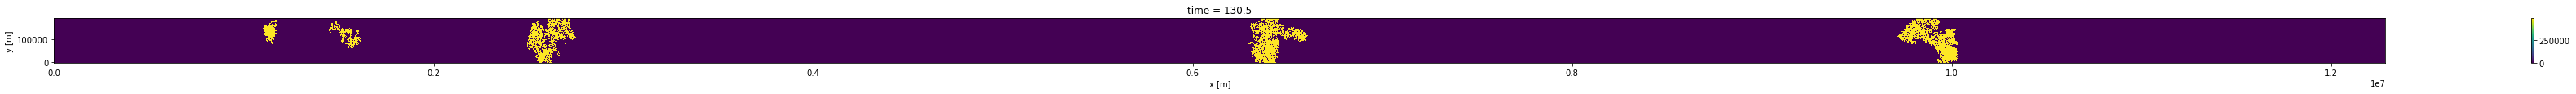

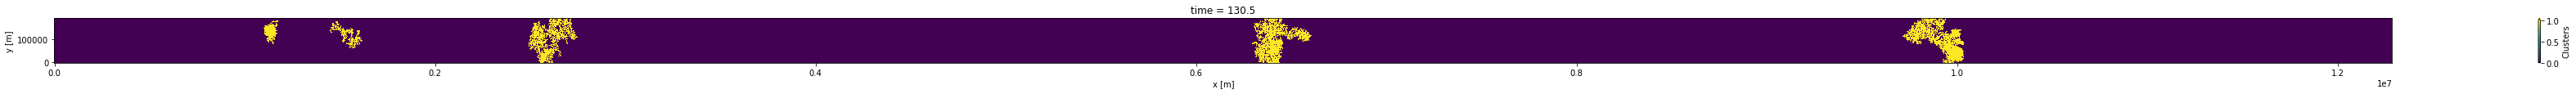

In [16]:
#from applying ndimage with time independent connected components structure to time-y-x binary dataarray
storms_alltime.isel(time=199).plot(figsize=(64,1))

#plotting the clusters from the data created with looping
xr_clust.Clusters.isel(time=199).plot(figsize=(64,1),vmin=0,vmax=1)

### Retrieving data for specific storm sites
Initial precipitation filter has been removed, using aloft condensate to set the principal values of the binary array, this produced a more reasonable number of storms.

Now data values need to be extracted and produced for each storm.

In [17]:
def buoy_xr(x_arr):
    
    
    tenv_xr = x_arr.TABS.mean(dim=['x','y'])

    qvenv_xr = x_arr.QV.mean(dim=['x','y'])

    qnenv_xr = x_arr.QN.mean(dim=['x','y'])
    
    
    buoyancy_xr = g*(x_arr.TABS - tenv_xr)/tenv_xr + (MWw/MWa)*(qvenv_xr - x_arr.QV) - (qnenv_xr - x_arr.QN)

    buoyancy_xr = xr.where(buoyancy_xr<0,0,buoyancy_xr)
    
    return buoyancy_xr.rename('buoyancy')
    
buoyancy_xr = buoy_xr(ds)

#buoyancy_xr

In [18]:
#cape = buoyancy_xr.integrate('z').rename('CAPE')

#cape

In [19]:
#print(ds.p[0].values)

#print(ds.p[10].values)

In [20]:
#ds_t199_pz = ds_t199.assign_coords(z=(ds_t199.p[::-1])*100)

#ds_pz = ds.assign_coords({'z':(ds.p[::-1])*100})

#cwvc = (ds_t199_pz.QV.integrate('z')/g).rename('CWVC')

#cwvc

def cluster_cwvc_3d(ds_xr):
    
    for i in np.arange(400):
        
        ds_xr_t = ds_xr.isel(time=i)
        
        ds_xr_t = ds_xr_t.assign_coords(z=(ds_xr_t.p[::-1])*100)
        
        labels = storm_labeller(ds_xr_t.binary)
        
        print(i)
        
        if i == 0:
            
            cwvc = ds_xr_t.QV.integrate('z')/g
            
            clusters = labels
            
        else:
            
            cwvc = xr.concat((cwvc,ds_xr_t.QV.integrate('z')/g),dim='time')
            
            clusters = xr.concat((clusters,labels),dim='time')
        
    return cwvc.rename('CWVC'),clusters.rename('Clusters')

#print(combined_xr)

#CWVC,labelled_clusters = cluster_cwvc_3d(combined_xr)

In [21]:
ds.p

<xarray.DataArray 'p' (time: 400, z: 64)>
dask.array<concatenate, shape=(400, 64), dtype=float32, chunksize=(1, 64), chunktype=numpy.ndarray>
Coordinates:
  * z        (z) float32 37.0 112.0 194.0 ... 2.696e+04 2.746e+04 2.796e+04
  * time     (time) float64 80.75 81.0 81.25 81.5 ... 179.8 180.0 180.2 180.5
Attributes:
    units:      mb
    long_name:  pressure

In [22]:
def svpl_xr(t_arr):
    
    R = 8.314             # J mol-1 K-1
    MWw = 18.015/1000     # kg mol-1
    rhoa = 1.395
    a1 = 54.842763
    a2 = -6763.22
    a3 = -4.21
    a4 = 0.000367
    a5 = 0.0415
    a6 = 218.8
    a7 = 53.878
    a8 = -1331.22
    a9 = -9.44523
    a10 = 0.014025
    
    factor = a7 + a8/t_arr + a9*xr.ufuncs.log(t_arr) + a10*t_arr
    
    psatL = a1 + a2/t_arr + a3*xr.ufuncs.log(t_arr) + a4*t_arr + xr.ufuncs.arctan(a5*(t_arr - a6))*factor
    
    psatL = xr.ufuncs.exp(psatL)
    
    return psatL

def sd_xr(xr_arr):
    
    return (eps*svpl_xr(xr_arr.TABS))/(xr_arr.p*100 - svpl_xr(xr_arr.TABS))*1000 - xr_arr.QV

def find_p(xr_arr,p_val):
    
    return xr_arr.where(xr_arr.p>p_val,drop=True).isel(z=-1)

In [23]:
'''
find function above seems to produce the wrong values, very unsure why..?
'''
#ds_550_f = find_p(ds,550)

#ds_700_f = find_p(ds,700)

#ds_850_f = find_p(ds,850)

#sd_mean_f = (sd_xr(ds_550_f)+sd_xr(ds_700_f)+sd_xr(ds_850_f))/3

ds_550 = ds.where(ds.p>550,drop=True).isel(z=-1)

ds_700 = ds.where(ds.p>700,drop=True).isel(z=-1)

ds_850 = ds.where(ds.p>850,drop=True).isel(z=-1)

sd_mean = ((sd_xr(ds_550)+sd_xr(ds_700)+sd_xr(ds_850))/3).rename('SD')

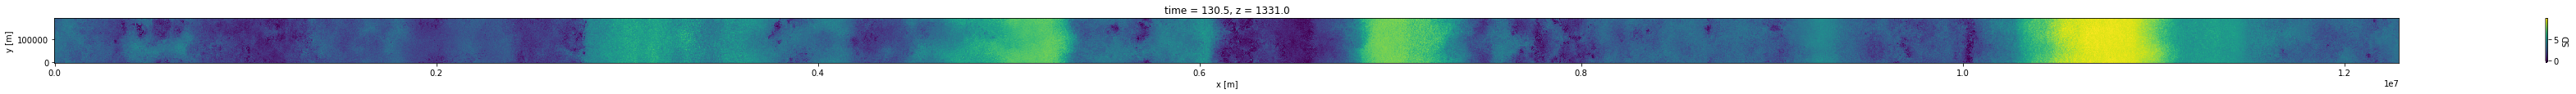

In [24]:
sd_mean[199].plot(figsize=(64,1),vmin=0)

# To be rewritten with clustering over time,y,x dataset without looping, cwvc with integral against z using z conversion to p levels, and hopefully grouping with max and mean both taken, either looping or at once if cluster tags dont conflict.

In [170]:
def super_xr(ds_xr):
    
    psurf = ds_xr.QP.isel(z=0).rename('psurf')

    qn_245 = ds_xr.QN.where(ds_xr.TABS<245)

    qn_245 = qn_245.bfill('z').isel(z=0).rename('qn245')
    
    mcs_xr = xr.where(qn_245<10**(-4),0,1).rename('binary')
    
    buoyancy_xr = buoy_xr(ds_xr)
    
    cape = buoyancy_xr.integrate('z').rename('CAPE')
    
    
    ds_550 = ds_xr.where(ds_xr.p>550,drop=True).isel(z=-1)

    ds_700 = ds_xr.where(ds_xr.p>700,drop=True).isel(z=-1)

    ds_850 = ds_xr.where(ds_xr.p>850,drop=True).isel(z=-1)


    sd_mean = ((sd_xr(ds_550)+sd_xr(ds_700)+sd_xr(ds_850))/3).rename('SD')

    measurements_xr = xr.combine_nested([psurf,qn_245,mcs_xr,cape,sd_mean,ds.p,ds.QV],concat_dim=[None],coords='minimal',compat='override')#,coords=['x','y','time'])
    
    #CWVC,labelled_clusters = cluster_cwvc_3d(measurements_xr)
    
    #measurements_clust = xr.combine_nested([measurements_xr,CWVC,labelled_clusters],concat_dim=[None],coords='minimal',compat='override')
    
    
    return measurements_xr#,measurements_clust

    #super_xr(ds)




    #create new arr with pressure vals as coords to enable integrating against
    #pressue with xr.integrate
    #ds_xr_pz = ds_t199.assign_coords(z=(ds_t199.p[::-1])*100)

    #cwvc = ds_t199_pz.QV.integrate('z')/g
    
#combined_xr = super_xr(ds)


In [171]:
#combined_xr.groupby('')

<xarray.DataArray 'SD' (time: 400, y: 64, x: 4096)>
dask.array<truediv, shape=(400, 64, 4096), dtype=float32, chunksize=(1, 64, 4096), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 0.0 3e+03 6e+03 9e+03 ... 1.228e+07 1.228e+07 1.228e+07
  * y        (y) float32 0.0 3e+03 6e+03 9e+03 ... 1.83e+05 1.86e+05 1.89e+05
  * time     (time) float64 80.75 81.0 81.25 81.5 ... 179.8 180.0 180.2 180.5

### Provisional netcdf data files are 'combined_clust_sst300.nc', which contains all field data pluts clusters and CWVC, and also 'combined_xr_sst300_2', which does not feature the clusters and CWVC.

In [155]:
def quick_plot(xrarr,time_i,var_str,v_max=None):
    
    xrarr.isel(time=time_i)[var_str].plot(figsize=(64,1),vmin=0,vmax=v_max)
    
    return

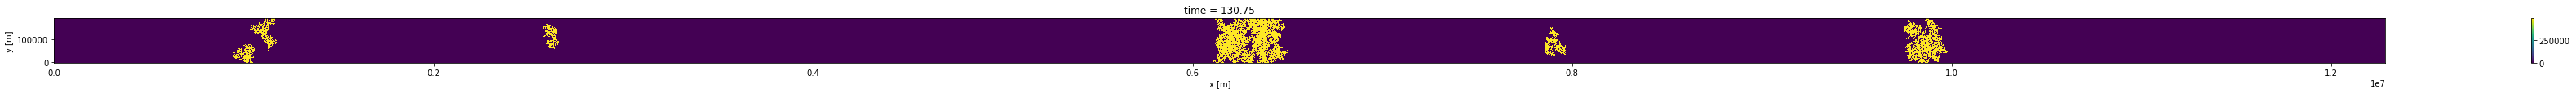

In [36]:
storms_alltime.isel(time=200).plot(figsize=(64,1))

In [16]:
xr_clust = xr.open_dataset('combined_clust_sst300.nc')

#quick_plot(xr_clust,199,'Clusters',v_max=1)

#xr_clust

### Group by with time slice seems to work, sort of, but for example visual check of psurf values seem to change when you change from a slice of 199 to 200 to one of 199 to 203, i.e. values are lost, perhaps this could be due to common cluster tags mixing data

### seems data is arbitrarily maintained between different slices, hard to tell qualitatively if things are being muddled up

In [42]:
#list(xr_clust.isel(time=199).groupby('Clusters'))[1:][1][1].CAPE.mean().values

xr_clust.isel(time=slice(199,201)).groupby('Clusters').max()

<xarray.Dataset>
Dimensions:   (Clusters: 12, z: 64)
Coordinates:
  * z         (z) float32 37.0 112.0 194.0 ... 2.696e+04 2.746e+04 2.796e+04
  * Clusters  (Clusters) int64 0 5 33 49 67 74 416 621 696 735 902 1205
Data variables:
    psurf     (Clusters) float64 3.964 0.004831 0.4533 ... 0.004707 2.274 0.0
    qn245     (Clusters) float64 5.395 0.4355 0.7326 ... 0.3599 3.211 0.3374
    binary    (Clusters) int64 1 1 1 1 1 1 1 1 1 1 1 1
    CAPE      (Clusters) float64 2.14e+04 1.822e+03 ... 8.994e+03 1.834e+03
    SD        (Clusters) float64 9.855 2.585 3.084 3.661 ... 2.744 2.824 4.121
    p         (Clusters, z) float32 1.008e+03 999.2 989.9 ... 16.98 15.63 14.38
    QV        (Clusters, z) float32 18.56 18.02 17.59 ... 0.005 0.005 0.005
    CWVC      (Clusters) float64 6.397e+03 4.844e+03 ... 5.436e+03 4.362e+03

In [ ]:
def super_df(file_names):

    for k,file_name in enumerate(file_names):
        
        print(file_name)
        
        file = xr.open_dataset(file_name)
        
        ################################
        #calling file variables
        ################################
        
        temp,precip,qn,qv,press,z,w = variables_get(file,['TABS','QP','QN','QV','p','z','W'])
        
        psurf = precip[0,0]
        
        ################################
        #filtering 
        ################################
        
        #setting up a binary array
        mcs = np.ones((64,4096))
        
        #call z search function for temp and qn
        qn_245 = search_z(temp,qn,0,245)

        #set mcs values < 0 to 0 in boolean array
        mcs[np.where(qn_245<10**(-4))] = 0
        
        ######################################################################
        #clustering and collocating
        ######################################################################
       
        ##########
        #Clustering
        ##########
        
        clusters_,clusters_storms = clusters(mcs,310)
        
        print(clusters_storms[1])
        
        ###########
        #Buoyancy
        ###########
        """
        Buoyancy calculation should be in a function but cannot seem to get one to work, hence
        the many lines
        """
        
        #calculate environmental variables, averaging over x and y for each z level
        tenv = np.mean(np.mean(temp[0],1),1)

        qvenv = np.mean(np.mean(qv[0],1),1)

        qnenv = np.mean(np.mean(qn[0],1),1)

        #calculate buoyancy profile using environmental variables
        buoy = g*(temp - tenv)/tenv + (MWw/MWa)*(qvenv - qv) - (qnenv - qn)

        ### buoy = buoy[0]
    
        #filtering and collocating buoyancy
        buoy = np.where(buoy[0]<0,0,buoy[0])

        #############
        #cape
        #############
        
        cape = integrate_z(buoy,z.data)

        ##############
        #saturation deficit
        ##############
        
        sd_avg = sd_mean(press,[550,700,850],qv,temp)
         
        ###################################################
        #arranging data by storm tag
        ###################################################
  
        vals_unique = np.unique(clusters_storms[0])[1:]

        output_arr = np.empty((len(vals_unique),5))

        for i,val in enumerate(vals_unique):
            
            #print(np.shape(buoy_col),np.shape(cape_col),np.shape(sd_avg_col),np.shape(psurf_col))

            #find indices associated with the numerical tag,corresponding to 1 storm
            indices = np.where(clusters_storms[0] == val)

            #extract the variable values from these desired elements            
            output_arr[i] = [np.mean(buoy[0][indices]),np.mean(cape[indices]),
                             np.mean(sd_avg[indices]),np.max(psurf[indices]),
                            np.mean(cwvc[indices])]
            
            #print(np.shape(buoy_col),np.shape(cape_col),np.shape(sd_avg_col),np.shape(psurf_col))
        
        
        if k == 0:
            
            super_output = output_arr
            
        else:
            
            super_output = np.vstack((super_output,output_arr))
            
    super_output = {'Mean Surface Buoyancy': super_output[:,0],
                    'Mean Cape': super_output[:,1],
                    'Mean Saturation Deficit': super_output[:,2],
                    'Max Surface Precipitation':super_output[:,3],
                    'Column Water Vapour Content':super_output[:,4]}
    super_output = pd.DataFrame(data=super_output)

    return super_output

In [ ]:
super_dataframe = super_df(files)
super_dataframe.to_csv(new_file_name,index=False)

In [ ]:
def maxk_arg(matrix,k):
    #returns indices of max k elements in a matrix
    
    matrix_new = matrix.flatten()
    
    matrix_arg = np.argsort(matrix_new)
    
    return matrix_arg[-k:]


def bin_stat_function(n_bins,lower,upper,x_variable,y_variable,threshold=0,pc1=95,pc2=99.99,n_max=5):
    #Creates a range of bin values within which the data should lie, collects indices of x-variables
    #which fall in those bins and calls the corresponding y-variable values, calculates means
    #and percentiles. 
    
    #n_bins = number of bins, lower and upper = bounds of bins, threshold is a required number
    #of values to have if statistics are to be calculated, pc1,2 are percentiles, assumed 95 and 99
    
    cc = np.linspace(lower,upper,n_bins)
    
    #nan filled arrays created
    
    x_bins = nan_array((n_bins,1))
    y_bins = nan_array((n_bins,1))
    
    y_bins_pc1 = nan_array((n_bins,1))
    y_bins_pc2 = nan_array((n_bins,1))
    
    x_max = nan_array((n_bins,n_max))
    y_max = nan_array((n_bins,n_max))
    
    x_bins_error = nan_array((n_bins,1))
    y_bins_error = nan_array((n_bins,1))
    
    
    #reduced bin values for the loop below
    cc_red = cc[:-1]
    
    for i,value in enumerate(cc_red):
        
        #indices of values within bins
        j = np.where((x_variable >= value) & (x_variable < cc[i+1]))

        x_vals = x_variable[j]
        y_vals = y_variable[j]

        #threshold inspected    
        if len(j[0]) > threshold:
            
            #mean of x values within bin
            x_bins[i] = np.nanmean(x_vals)
            x_bins_error[i] = np.nanstd(x_vals)   
            
            #mean and percentiles of associated y variable
            y_bins[i] = np.nanmean(y_vals)
            y_bins_error[i] = np.nanstd(y_vals)
    
            y_bins_pc1[i] = np.nanpercentile(y_vals,pc1)
            y_bins_pc2[i] = np.nanpercentile(y_vals,pc2)

        if len(j[0]) >= n_max:
        
            j = maxk_arg(y_vals,n_max)

            
            x_max[i] = x_vals[j]
            
            y_max[i] = y_vals[j]
    

    return x_bins,y_bins,y_bins_pc1,y_bins_pc2,x_bins_error,y_bins_error,x_max,y_max


In [ ]:
plt.scatter(big_data[:,2],big_data[:,1])
plt.show()

sd_bins,cape_mean,cape_95,cape_99,sd_err_x,cape_err_y,sd_max_x,cape_max_y = bin_stat_function(100,0.5,5,big_data[:,2],
                                                                                      big_data[:,1],threshold=0,
                                                                                      pc1=95,pc2=99.99,n_max=2)

#plt.errorbar(sd_bins,cape_mean,xerr=sd_err_x,yerr=cape_err_y,color='k',ls='none')
#plt.scatter(sd_bins,cape_95,color='orange')
plt.scatter(sd_bins,cape_99,color='red')
#plt.scatter(sd_max,cape_max,color='purple')

plt.show()

In [ ]:
plt.scatter(big_data[:,1],big_data[:,3])
plt.show()

cape_bins,pmax_mean,pmax_95,pmax_99,cape_err_x,pmax_err_y,cape_max_x,pmax_max_y = bin_stat_function(85,0,3500,big_data[:,1],
                                                                                      big_data[:,3],threshold=0,
                                                                                      pc1=95,pc2=99.99,n_max=2)

plt.errorbar(cape_bins,pmax_mean,xerr=cape_err_x,yerr=pmax_err_y,color='k',ls='none')
#plt.scatter(cape_bins,pmax_95,color='orange')
#plt.scatter(cape_bins,pmax_99,color='red')
#plt.scatter(cape_max_x,pmax_max_y,color='purple')

plt.show()

In [ ]:
plt.scatter(big_data[:,2],big_data[:,3])
plt.show()

sd_p_bins,pmax_sd_mean,pmax_sd_95,pmax_sd_99,sd_p_err_x,pmax_sd_err_y,sd_p_max_x,pmax_sd_max_y = bin_stat_function(85,0,2.5,big_data[:,2],
                                                                                      big_data[:,3],threshold=0,
                                                                                      pc1=95,pc2=99.99,n_max=2)

plt.errorbar(sd_p_bins,pmax_sd_mean,xerr=sd_p_err_x,yerr=pmax_sd_err_y,color='k',ls='none')
#plt.scatter(sd_p_bins,pmax_sd_95,color='orange')
#plt.scatter(sd_p_bins,pmax_sd_99,color='red')
plt.scatter(sd_p_max_x,pmax_sd_max_y,color='purple')

plt.show()

In [196]:
struct = np.zeros((3,3,3))

struct[1] = [[0,1,0],[1,1,1],[0,1,0]]

print(struct)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 1. 0.]
  [1. 1. 1.]
  [0. 1. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [ ]:
x = np.load('buoy_cape_sd_pmax_300.npy')

# TO DO

- IMPORTANT nan argsort in era5 notebook, nan argsort doesnt find the values because there are nan values being chosen as max values XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

- change sd scaling by 1000, cut off at 0 .... buoyancy model only takes positive sd (in ERA 5 file)

- when other sst files are uploaded, save as npy files

- load new npy files into a master analysis notebook,then perform the bin analysis using the combined sst files

- make sure to retain individual sst files to see if trends are similar over different ssts

- w,p loading 

- create cwvc variable function in draft notebook (THIS) , with a field as usual



## Scrap Code

In [ ]:
def nan_array(shape):
    
    an_array = np.empty(shape)

    an_array[:] = np.NaN
    
    return an_array

x = nan_array((10))

print(np.where(np.isnan(x)==True,5,x))

In [ ]:
"""
qn_245 = np.zeros((64,4096))

print(np.size(qn_245))

x = np.where(qn_245 ==0)

print(len(x[1]))

#print(np.where(temp[0,5,:,:] > 0))


for z_i in np.arange(0,64):
    
    tb_245 = np.where(temp[0,z_i,:,:].data < 245)
    
    print(len(tb_245[0]))
    
    print('################')
    
    #print(np.shape(tb_245))
    
    qn_245 = qn[0,z_i,tb_245[0],tb_245[1]]
"""


"""
x = np.random.randint(100,size=(10,10,10))

print(np.shape(x))
#print((x))

for z_i in np.arange(0,10):
    
    z_val = np.where(x[z_i,:,:] > 50)
    
    print(z_val[0],z_val[1])
    print('###############################')


#z = np.where(x<50,-1,x)

#print('###############################')
#print(z)

"""

"""
for x in np.arange(0,4096):
    
    print(x)
    
    for y in np.arange(0,64):
        
        print(y)
        
        tb_245 = np.where(temp[0,:,y,x]<245)[0][0]
        
        qn_245[y,x] = qn[0,tb_245,y,x]

mcs = np.where(qn_245 < 0,0,mcs)        
"""


"""
i_245 = nan_array(262144)

dummy = 0

for z_i in np.arange(0,64):
#iterate over all z levels
    
    if len(np.where(np.isnan(i_245)==False)[0]) < 262144:   
        #iterate over all z levels
        
        #create empty dummy arrays
        i_0 = nan_array(262144)
        
        #collect indices where t, at given z, is less than 245K
        indices = np.where(temp[0,z_i,:,:].data.flatten() < 245)
        
        
        if len(indices[0]) > 0:
            
            
            i_0[indices] = indices
        
            i_245_new = i_0
            
            dummy += 1  
            
            
            if dummy == 1:
                
            
                i_245 = i_245_new
            
            
                zi_0 = nan_array(262144)
            
                zi_0[indices] = z_i
            
                zi_245 = zi_0
            
            else:
                            
                i_diff = np.where(i_245 != i_245_new)

                i_245[i_diff] = i_245_new[i_diff]
            
                zi_245[i_diff] = z_i
                
print(i_245)
                

"""

"""
def search_z(four_d_arr,time_index,less_than_val):
    
    xy_size = np.size(four_d_arr[time_index,0,:,:])
    
    i_arr = nan_array(xy_size)

    dummy = 0

    for z_i in np.arange(0,len(four_d_arr[time_index,:,0,0])):
    #iterate over all z levels
    
    
        if len(np.where(np.isnan(i_arr)==False)[0]) < xy_size:   
        
            #create empty dummy arrays
            i_0 = nan_array(xy_size)
        
            #collect indices where the array, at given z, is less than the prescribed value
            indices = np.where(four_d_arr[time_index,z_i,:,:].data.flatten() < less_than_val)
        
        
            if len(indices[0]) > 0:
            
            
                i_0[indices] = indices
        
                i_arr_new = i_0
            
                dummy += 1  
            
            
                if dummy == 1:
                
            
                    i_arr = i_arr_new
            
            
                    zi_0 = nan_array(xy_size)
            
                    zi_0[indices] = z_i
            
                    zi_arr = zi_0
            
                else:
                            
                    i_diff = np.where(i_arr != i_arr_new)

                    i_arr[i_diff] = i_arr_new[i_diff]
            
                    zi_arr[i_diff] = z_i
                
    zi_arr = zi_arr.astype('int32') 
    
    xyz_indices = np.array([],dtype=int)
    
    for i,value in enumerate(zi_arr):
    
        xyz_indices = np.append(xyz_indices,value*(xy_size) + i)
    
    return xyz_indices
                
              
full_indices = search_z(temp,0,245)

print(full_indices)
"""

"""
#convert Boolean array into integers
mcs = mcs.astype('int32')

#call the labels and number of clusters using ndimage
labels,nb = ndimage.label(mcs)

#plot the labelled clusters
fig,ax = plt.subplots(figsize = (64*4,4))
ax.imshow(labels)
plt.show()

#find the sizes of each object, in terms of pixels 
pixelsizes = ndimage.sum(mcs,labels,range(nb+1))

#create a boolean array for whether the objects 
#are larger than a given threshold
mask_size = pixelsizes < 310

#indices of pixels to be removed are produced
remove_pixel = mask_size[labels]

#indices and thus objects are removed based on object size
labels[remove_pixel] = 0

#second figure produced
fig,ax = plt.subplots(figsize = (64*4,4))

ax.imshow(labels)

plt.show()
"""


#qn_245_3 = search_z(temp,0,245,qn)

"""
#set mcs values < 0 to 0 in boolean array
mcs_1[np.where(qn_245_3<0)] = 0

#colormesh of qn_245_2
fig,ax = plt.subplots(figsize = (64*4,4))

#showing the qn_245 array
mesh_qn = ax.pcolormesh(qn_245_3,cmap='Greys')

plt.show()

print(qn_245_2[np.where(qn_245_2!=0)],qn_245_2[np.where(qn_245_3!=0)])
"""

#qn_245_check = qn_245_3 - qn_245_2

#colormesh of qn_245_2
#fig,ax = plt.subplots(figsize = (64*4,4))

#showing the qn_245 array
#mesh_qn = ax.pcolormesh(qn_245_check,cmap='Greys')

#plt.show()

"""
def search_z(four_d_arr,time_index,less_than_val,four_d_arr_2):
    #function that searches an array four_d_arr for the z values at each x,y value, 
    #where the data is below a given value {{ could be edited to be another condition???}}
    
    #four_d_arr [time,z,y,x], array for inspection
    #time_index to take values at 
    #less_than_val is the value which elements need to be below to be taken
    #four_d_arr_2 is the second array to then extract values from using the four_d_arr indices of interest
    
    #take shape of input arr
    xy_shape = np.shape(four_d_arr[time_index,0,:,:])
    
    #calculate total size
    xy_size = xy_shape[0]*xy_shape[1]
    
    #initialise empty data array for later outputting
    arr_2d = np.zeros(xy_size)
    
    #array of indices, used internally
    i_arr = nan_array(xy_size)

    #used to set off first instance where values are found
    dummy = 0

    for z_i in np.arange(0,len(four_d_arr[time_index,:,0,0])):
    #iterate over all z levels
    
        #only keep searching when not all values in 2d xy array are filled
        if len(np.where(np.isnan(i_arr)==False)[0]) < xy_size:   
        
            #create empty dummy arrays
            i_0 = nan_array(xy_size)
        
            #collect indices where the array, at given z, is less than the prescribed value
            indices = np.where(four_d_arr[time_index,z_i,:,:].data.flatten() < less_than_val)
        
            if len(indices[0]) > 0:

                #empty index array filled with indices
                i_0[indices] = indices
        
                i_arr_new = i_0
                
                dummy += 1  
            
                if dummy == 1:
                
                    i_arr = i_arr_new
                
                    #arr_2d is added to by corresponding values in secondary array, at correct z and xy
                    arr_2d[indices] = (four_d_arr_2[time_index,z_i].data.flatten())[indices]
            
                else:
                    
                    #check to only add where existing values are not present
                    #this means only values taken from first found z levels are used
                    i_diff = np.where(i_arr != i_arr_new)

                    arr_2d[i_diff] = (four_d_arr_2[time_index,z_i].data.flatten())[i_diff]
                    
    #reshape to be same as original xy array
    arr_2d = np.reshape(arr_2d,xy_shape)
    
    return arr_2d
"""

"""
def integrate_z(arr,z_list):
    
    arr_flat = list(map(lambda arr: arr.flatten(),arr))
    
    #print(arr_flat)
    print(arr_flat[:][0])
    
    length = len(arr_flat[0])
    
    arr_out = np.empty(length)
    
    for i in np.arange(0,length):
        
    
        arr_out[i] = np.trapz(x=z_list,y=arr_flat[:][0][i])
        
    return arr_out

integrate_z(buoy,z_2.data)
"""


"""
index_550,p_550 = find_less(press_2,550,1)

qv_550 = qv_2[0,index_550].data

qv_550 = np.where(mcs==1,qv_550,np.NaN)

#print(len(np.where(np.isnan(qv_550)==False)[0]))

t_550 = temp_2[0,index_550].data

t_550 = np.where(mcs==1,t_550,np.NaN)

sd_550 = sd(qv_550,p_550,t_550)

print(qv_550)
print(t_550)
#print(sd_550)

#print(len(np.where(np.isnan(sd_550)==False)[0]))
print('################################')

"""

"""
fig,ax = plt.subplots(figsize=(64*4,4))

ax.imshow(psurf)

plt.show()


fig,ax = plt.subplots(figsize=(64*4,4))

ax.imshow(clusters_1[0],cmap='Greys')

plt.show()


psurf = np.where(clusters_1[0]==0,0,psurf)


fig,ax = plt.subplots(figsize=(64*4,4))

ax.imshow(psurf)

plt.show()
"""

"""
fig,ax = plt.subplots(figsize=(64*4,4))

ax.imshow(cape)

plt.show()


fig,ax = plt.subplots(figsize=(64*4,4))

ax.imshow(clusters_1[0])

plt.show()


cape = np.where(clusters_1[0]==0,0,cape)


fig,ax = plt.subplots(figsize=(64*4,4))

ax.imshow(cape)

plt.show()

"""

"""
fig,ax = plt.subplots(figsize = (64*4,4))
ax.imshow(mcs_0,cmap='Greys')
plt.show()

#cluster function called on mcs, with size corresponding to 
#equivalent radius of 90km
clusters_0,clusters_1 = clusters(mcs_0,310)

#plot the labelled clusters
fig,ax = plt.subplots(figsize = (64*4,4))
ax.imshow(clusters_0[0])
plt.show()

#second figure produced
fig,ax = plt.subplots(figsize = (64*4,4))
ax.imshow(clusters_1[0])
plt.show()

print(np.unique(clusters_1[0]))
print(clusters_1[1])
"""


#fig,axes = plt.subplots(3,1,figsize=(64*4,4))

#im_1 = axes[0].imshow(mcs_0,cmap='Greys')

#im_2 = axes[1].imshow(buoy,vmin=np.min(buoy),vmax=np.max(buoy))

#im_3 = axes[2].imshow(buoy_1,vmin=np.min(buoy),vmax=np.max(buoy))

#cb_ax = fig.add_axes([0.628, 0.05, 0.0025, 0.9])
#fig.colorbar(im_2, ax=axes.ravel().tolist(),pad=0.001)

#plt.show()


#call the sd generating routine for 3 pressure levels of interest
#sd_550 = sd_plev(press_2,550,qv_2,temp_2)
#sd_700 = sd_plev(press_2,700,qv_2,temp_2)
#sd_850 = sd_plev(press_2,850,qv_2,temp_2)

#collate arrays and reshape to iteratable form
#sd_arrs = np.reshape([sd_550,sd_700,sd_850],(3,64,4096))
#print(sd_arrs)

#avergae over every x,y site
#sd_avg = np.mean(sd_arrs,0)

#sd_collocated = field_plots(clusters_1[0],sd_avg,['Saturation Deficit','N'])


"""
def data_xr(file_names):

    for k,file_name in enumerate(file_names):
        
        file = xr.open_dataset(file_name)
        
        ################################
        #calling file variables
        ################################
        
        temp,precip,qn,qv,press,z,w = variables_get(file,['TABS','QP','QN','QV','p','z','W'])
        
        psurf = precip[0,0]
        
        ################################
        #filtering 
        ################################
        
        #setting up a binary array
        mcs = np.ones((64,4096))
        
        #call z search function for temp and qn
        qn_245 = search_z(temp,qn,0,245)

        #set mcs values < 0 to 0 in boolean array
        mcs[np.where(qn_245<10**(-4))] = 0
        
        ######################################################################
        #clustering and collocating
        ######################################################################
       
        ##########
        #Clustering
        ##########
        
        clusters_,clusters_storms = clusters(mcs,310)
        
        ###########
        #Buoyancy
        ###########
        """
        Buoyancy calculation should be in a function but cannot seem to get one to work, hence
        the many lines
        """
        
        #calculate environmental variables, averaging over x and y for each z level
        tenv = np.mean(np.mean(temp[0],1),1)

        qvenv = np.mean(np.mean(qv[0],1),1)

        qnenv = np.mean(np.mean(qn[0],1),1)

        #calculate buoyancy profile using environmental variables
        buoy = g*(temp - tenv)/tenv + (MWw/MWa)*(qvenv - qv) - (qnenv - qn)

        ### buoy = buoy[0]
    
        #filtering and collocating buoyancy
        buoy = np.where(buoy[0]<0,0,buoy[0])

        #############
        #cape
        #############
        
        cape = integrate_z(buoy,z.data)

        ##############
        #saturation deficit
        ##############
        
        sd_avg = sd_mean(press,[550,700,850],qv,temp)
         
        ###################################################
        #arranging data by storm tag
        ###################################################
  
        vals_unique = np.unique(clusters_storms[0])[1:]

        output_arr = np.empty((len(vals_unique),4))
        
        #print(output_arr)

        for i,val in enumerate(vals_unique):
            
            #print(np.shape(buoy_col),np.shape(cape_col),np.shape(sd_avg_col),np.shape(psurf_col))

            #find indices associated with the numerical tag,corresponding to 1 storm
            indices = np.where(clusters_storms[0] == val)

            #extract the variable values from these desired elements            
            output_arr[i] = [np.mean(buoy_col[0][indices]),np.mean(cape_col[indices]),
                             np.mean(sd_avg_col[indices]),np.max(psurf_col[indices])]
            
            #print(np.shape(buoy_col),np.shape(cape_col),np.shape(sd_avg_col),np.shape(psurf_col))
        
        
        if k == 0:
            
            super_output = output_arr
            
        else:
            
            super_output = np.vstack((super_output,output_arr))

    #ds = xr.Dataset(
     #   {"buoyancy": super_output[:,0]},
      #  {"cape": super_output[:,1]},
       # {"sd": super_output[:,2]},
        #{"pmax": super_output[:,3]})

    #ds.to_netcdf("collocated_storms_all.nc")
    
    return super_output

big_data = data_xr(files)
"""
"""
def nan_array(shape):
    #function to create arrays filled with np nan values

    #empty array
    an_array = np.empty(shape)

    #iterate thhrough array setting to nans
    an_array[:] = np.NaN

    return an_array


def place_counter(asc_array,N=1):
    #function to find number of places taken up by values, eg 1000
    #occupies 4 spaces, 11358 takes 5.
    #asc_array, an array where values only increase 
    #N = number of places of first value

    n_places = np.array([],dtype=int)

    n = N
   
    for val in asc_array:

        while val//(10**n) >= 1:
        
            n += 1
        
        #fill list with number of places
        n_places = np.append(n_places,int(n))
        
    return n_places
    
def file_suffix_maker(zero_number,lower,upper,step):
    #many file suffixes feature strings with adjacent 0s, like '00000'
    #these are hard to make simply, and this function is required to make them
    
    zero_str_arr = []
    
    array = np.arange(lower,upper,step)
    
    #find number of places,set to start at 4 as files in this notebook start with time 1800
    places = place_counter(array,N=4)
    
    for i,val in enumerate(array):
        
        #number of 0s required
        zero_number_new = zero_number - places[i]
        
        #creates string with prefix of 0s
        zero_str = str(0)*zero_number_new + str(val)
        
        zero_str_arr = np.append(zero_str_arr,zero_str)
        
    return zero_str_arr

#file_suffixes = file_suffix_maker(10,1800,721800,1800)

def file_concatenator(sst,zero_number,lower,upper,step):
    #Takes a list of numbers corresponding to filenumbers/years 
    #and compiles the corresponding list of filenames
    
    file_names = []
    
    #base directory where the desired files are located
    basedir = '/work/bb1018/b380873/RCE-CAPE-exploration/RCE-sims/ch_cam' + str(sst) + 'ri0/'
    
    file_suffixes = file_suffix_maker(zero_number,lower,upper,step)
    
    #iterates through numbers
    for suffix in file_suffixes:
        
        #appending list of files
        file_names = np.append(file_names,(basedir+'ch_cam'+str(sst)+'ri0_4096x64x64'
                                           +'_3km_12s_cam'+str(sst)+'ri0_64_'+suffix+'.nc'))
        
    return file_names
"""



#choose the 200th file of 400 to consider initially, while developing the code
#file_init = ds[199]

#file_init

#qn245 = qn[0,24]
#plt.figure(figsize=(10,5))
#plt.hist(qn245.data.flatten(),bins=np.logspace(-10,1,50))
#plt.gca().set_xscale('log')
#plt.show()
# It seems no files have negative values in qn, so i'm not sure if this is meant to be used later on for q_245

"""
def variables_get(file_obj,var_names):
    
    output = [[]]*len(var_names)
    
    for i,var_name in enumerate(var_names):
        
        
        output[i] = file_obj[var_name]
        
    return output
"""

#tt,qqpp,qqnn = variables_get(file_init,['TABS','QP','QN'])

#print(tt)

#print(qqnn)

#ppp = ppp[::-1]

#ds.isel(time=199)


#where surface precipitation is 0, binary array = 0
#mcs = np.where(psurf==0,0,mcs)

#calling the mcs boolean mesh to view at this stage
#colour mesh of mcs
#fig,ax = plt.subplots(figsize = (64*4,4))

#ax.pcolormesh(mcs,cmap='Greys')

#plt.show()

#mcs_xr = xr.where(qn_245<10**(-4),0,mcs_xr)

#mcs_xr.plot(figsize=(64,1))

#mcs_xr = xr.DataArray(np.ones((64,4096)),
 #                     dims=['y','x'],
  #                    coords={'y':ds.y.values,'x':ds.x.values})

"""
def search_z(arr_4d_0,arr_4d_1,time_index,less_than_val):
    #similar function to search_z, iterates over all z, in reverse, filling in 
    #an otherwise nan filled array with values from arr_4d_1, of indices corresponding
    #to values in arr_4d_0 satisfying a critical value relation
    
    #both input arrays have structure time,z,y,x (hence 4d)
    #time index generalised but only 0 here
    #critical_val is a value elements must be greater or equal to in the principal array  

    #array of nans constructed, 2d array of y and x
    arr_2d = nan_array(np.shape(arr_4d_0[time_index,0]))
    
    #find length of z array
    z_len = len(arr_4d_0[time_index,:,0,0])

    #iterate from last z values first
    for z_i in np.arange(0,z_len):
    #iterate over all z levels
    
        #print(z_i) #counter

        #check that all elements haven't been filled
        if len(np.where(arr_4d_0[time_index,z_i,:,:] < less_than_val)[0]) > 0:
    
            empty_indices = np.where(np.isnan(arr_2d)==True)
            
            #print(len(empty_indices[0])) # filling check
            
    
            #check that all elements haven't been filled
            if len(empty_indices[0]) > 0:
            
                #print('##########')  #signal start of filling
            
                #replace only the empty array sites using corresponding
                #subset of arr_4d_0 and 1
                arr_2d[empty_indices] = np.where(arr_4d_0.data[time_index,z_i][empty_indices] < less_than_val,
                                                 arr_4d_1.data[time_index,z_i][empty_indices],
                                                 arr_2d[empty_indices])
                
            else:
            
                break
    
    return arr_2d



#call z search function for temp and qn
qn_245_2 = search_z(temp,qn,0,245)

#print(qn_245_2)

#set mcs values < 0 to 0 in boolean array
mcs_0[np.where(qn_245_2<10**(-4))] = 0


#zero values less than 0...?
#print(len(np.where(qn_245_2<10**(-4))[0]))

#colormesh of qn_245_2
fig,ax = plt.subplots(figsize = (64*4,4))

#showing the qn_245 array
mesh_qn = ax.pcolormesh(qn_245_2,cmap='Greys')

plt.show()
"""

"""
def clusters(arr,size):
    #function using the scipy ndimage package to find connected
    #components in the inputted boolean array and then also outputs
    #clusters only above a certain pixel size threshold
    
    #arr is boolean array, size is the threshold size which clusters
    #need to be above
    
    #outputs the original object labels and the number of clusters
    #labels_0 and nb_0 respectively.Then the corresponding reduced 
    #array and cluster number, labels_1 and nb_1 are outputted
    
    #convert Boolean array into integers
    arr = arr.astype('int32')
    
    #call the connected components and number of clusters using ndimage
    #uses 4 point connectivity
    labels_0,nb_0 = ndimage.label(arr)
    
    #create new duplicate local variable labels_1, the edited array
    labels_1 = copy.deepcopy(labels_0)
    
    #find the sizes of each object, in terms of pixels 
    pixelsizes = ndimage.sum(arr,labels_1,range(nb_0+1))

    #create a boolean array for whether the objects 
    #are larger than a given threshold
    mask_size = pixelsizes < size
    
    nb_1 = len(np.where(mask_size==False)[0])

    #indices of pixels to be removed are produced
    remove_pixel = mask_size[labels_1]
    
    #indices and thus objects are removed based on object size
    labels_1[remove_pixel] = 0
    
    return [labels_0,nb_0],[labels_1,nb_1]


clusters_0,clusters_1 = clusters(mcs_0,310)


fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(64*4,14))

ax1.imshow(mcs_0,cmap='Greys')

ax2.imshow(clusters_0[0])

ax3.imshow(clusters_1[0])

plt.show()

def storm_collector(file_list):
    
    storm_number = np.array([],dtype='int')

    for i,file_name in enumerate(file_list):
        
        file = xr.open_dataset(file_name)
    
        #call temperature (absolute)
        temp = file.TABS

        #precipitating water
        precip = file.QP

        #non precipitating water
        qn = file.QN
    
        #setting up a binary array
        binary = np.ones((64,4096))
    
        #PRECIPITATION FILTER NOT APPLIED FIRST
    
        #calling the surface (z=0) level values
        #psurf = precip[0,0]
    
        #where surface precipitation is 0, binary array = 0
        #mcs = np.where(psurf==0,0,mcs)
        
        #qn values corresponding to lowest vertical position where temp < 245
        qn_245 = search_z(temp,qn,0,245)
        
        #set mcs values < 0 to 0 in boolean array
        binary[np.where(qn_245<10**(-4))] = 0
        
        objects,storms = clusters(binary,310)
        
        print(i,storms[1])
        
        storm_number = np.append(storm_number,storms[1])
        
        
    
    storm_tot = np.cumsum(storm_number)
    
    storm_mean = np.mean(storm_number)
    
    storm_std = np.std(storm_number)
    
    return storm_tot,storm_mean,storm_std

total,mean,std = storm_collector(files) 
"""
#######################################################################DEPTH STUFF#####################################
"""
def search_z_2(arr_4d_0,arr_4d_1,time_index,critical_val):
    #similar function to search_z, iterates over all z, in reverse, filling in 
    #an otherwise nan filled array with values from arr_4d_1, of indices corresponding
    #to values in arr_4d_0 satisfying a critical value relation
    
    #both input arrays have structure time,z,y,x (hence 4d)
    #time index generalised but only 0 here
    #critical_val is a value elements must be greater or equal to in the principal array  

    #array of nans constructed, 2d array of y and x
    arr_2d = nan_array(np.shape(arr_4d_0[time_index,0]))

    #iterate from last z values first
    for z_i in reversed(np.arange(0,len(arr_4d_0[time_index,:,0,0]))):
        #iterate over all z levels
    
        #print(z_i)
    
        if len(np.where(arr_4d_0[time_index,z_i,:,:] >= critical_val)[0]) > 0:
            
            #print('###########################')
            
            #finding indices to replace
            empty_indices = np.where(np.isnan(arr_2d)==True)
            
            #print(len(empty_indices[0]))
    
            #check that all elements haven't been filled
            if len(empty_indices[0]) > 0:
                
                #replace only the empty array sites using corresponding
                #subset of arr_4d_0 and 1
                arr_2d[empty_indices] = np.where(arr_4d_0.data[time_index,z_i][empty_indices] >= critical_val,
                                                 arr_4d_1.data[time_index,z_i][empty_indices],
                                                 arr_2d[empty_indices]) 
    
    return arr_2d

ctt = search_z_2(qn,temp,0,10**(-4))

#print(np.shape(ctt))

ts = temp[0,0,:,:]

depth = ts.data - ctt

print(np.shape(depth[~np.isnan(depth)]))

#depth = np.where(mcs==1,0,depth)

#print(np.shape(depth))

#colormesh of qn_245_2
fig,ax = plt.subplots(figsize = (64*4,4))

#showing the qn_245 array
ax.pcolormesh(depth[~np.isnan(depth)],cmap='Greens')

plt.colorbar()

plt.show()
"""

"""
#Considering the file before the input
#file_two = xr.open_dataset(files[199])

qv_2 = file_init.QV
#qv_2 = file_two.QV

#non precipitating water
qn_2 = file_init.QN
#qn_2 = file_two.QN

#pressure
press_2 = file_init.p
#press_2 = file_two.p

z_2 = file_init.z
#z_2 = file_two.z

#call temperature (absolute)
temp_2 = file_init.TABS
#temp_2 = file_two.TABS
"""
#emp_2 = ds_t199.TABS.values

#rint(temp_2)

#print(np.shape(temp_2))

#calculate environmental variables, averaging over x and y for each z level

#env = np.mean(np.mean(temp_2,1),1)

#tenv_xr = ds_t199.TABS.mean(dim=['x','y'])

#qvenv_xr = ds_t199.QV.mean(dim=['x','y'])

#qnenv_xr = ds_t199.QN.mean(dim=['x','y'])


#qvenv = np.mean(np.mean(qv_2[0],1),1)

#qnenv = np.mean(np.mean(qn_2[0],1),1)

#calculate buoyancy profile using environmental variables

#buoy_xr = g*(ds_t199.TABS - tenv_xr)/tenv_xr + (MWw/MWa)*(qvenv_xr - ds_t199.QV) - (qnenv_xr - ds_t199.QN)


"""
def field_plots(clusters,raw,var_name_unit):
    
    fig,axes = plt.subplots(3,1,figsize=(64*4,6))

    labels = ['Raw {} Field'.format(var_name_unit[0]),'Storm Filtered {} Field'.format(var_name_unit[0])]
    
    filtered = np.where(clusters==0,0,raw)
     
    
    im1 = axes[0].imshow(clusters,cmap='Greys',vmin=5,vmax=10)
                 
    axes[0].set_title('Storm Clusters')
            

                 
    im2 = axes[1].imshow(raw,vmin=np.min(raw),vmax=np.max(raw))
            
    axes[1].set_title(labels[0])
    
    axes[1].set_ylabel('Y Coordinates [$km$]',size=18)
    
    
    im3 = axes[2].imshow(filtered,vmin=np.min(raw),vmax=np.max(raw))
    
    axes[2].set_title(labels[1])
    
    axes[2].set_xlabel('X Coordinates [$km$]',size=18)

    
    #space between plots adjusted
    plt.subplots_adjust(hspace=0.5)
    
    plt.colorbar(im2, ax=axes.ravel().tolist(),pad=0.001,label='{0} [${1}$]'.format(var_name_unit[0],var_name_unit[1]))
    
    plt.suptitle('Field Outputs: Clusters vs Raw {} Field'.format(var_name_unit[0]),x=0.6375,y=1.01,size=18)
 
    plt.show()
            
    return filtered
        
buoy_collocated = field_plots(clusters_1[0],buoy[63],['Buoyancy','N'])
"""

"""
def sub_arr_flat(arr):
    
    #print(np.shape(arr))
    
    xy_len = len(arr[0].flatten())
    #print(xy_len)
    
    z_len = len(arr[:,0,0])
    #print(z_len)
    
    arr_flat = np.empty((z_len,xy_len))
    
    for i in np.arange(z_len):
        
        arr_flat[i] = arr[i].flatten()
    
    return arr_flat,xy_len
      
def integrate_z(arr,z_vals):
    
    arr_flat,length = sub_arr_flat(arr)
    
    #print(np.shape(arr_flat))
    
    arr_out = np.empty(length)
    
    for i in np.arange(0,length):
        
        arr_out[i] = np.trapz(x=z_vals,y=arr_flat[:,i])
        
    return np.reshape(arr_out,(np.shape(arr[0])))
"""

#cape = integrate_z(buoy,z_2.data)

#cape_collocated = field_plots(clusters_1[0],cape,['CAPE','J Kg^{-1}'])

"""
def find_less(array,value,number):
    #function to find 'number' of initial values in 'array' greater
    #than some 'value'
    
    #array here has descending values, designed for pressure array going
    #from 1000 to 14
    
    #indices of values in array greater than the user value
    k = np.where(array>value)
    
    #number of values greater than the value to be chosen
    #i.e. 1 gives the value closest, 2 gives the two closes
    values = (array[k])[-number:]
    
    indices = k[0][-number:]
        
    return indices,values.data

def satVapP_liq(t_in):
    R = 8.314             # J mol-1 K-1
    MWw = 18.015/1000     # kg mol-1
    rhoa = 1.395
    a1 = 54.842763
    a2 = -6763.22
    a3 = -4.21
    a4 = 0.000367
    a5 = 0.0415
    a6 = 218.8
    a7 = 53.878
    a8 = -1331.22
    a9 = -9.44523
    a10 = 0.014025
    factor = a7 + a8/t_in + a9*np.log(t_in) + a10*t_in
    psatL = a1 + a2/t_in + a3*np.log(t_in) + a4*t_in + np.arctan(a5*(t_in - a6))*factor
    psatL = np.exp(psatL)
    return psatL

def sd(qv_value,p_value,t_value):
    #function to calculate saturation deficit given water content,pressure and temperature
    
    return (eps*satVapP_liq(t_value))/(p_value*100 - satVapP_liq(t_value))*1000 - qv_value


def sd_plev(p_arr,p_val,qv_arr,t_arr):
    
    arrs_vals = np.empty((2,64,4096))
    
    idx,p = find_less(p_arr,p_val,1)

    for i,arr in enumerate([qv_arr,t_arr]):
        
        arr_val = arr[0,idx].data
        
        arrs_vals[i] = arr_val
        
    return sd(arrs_vals[0],p,arrs_vals[1])

def sd_mean(p_arr,plevs,qv_arr,temp_arr):
    
    sd_arrs = np.empty((3,64,4096))
    
    for i in range(len(sd_arrs)):
        
        sd_arrs[i] = sd_plev(p_arr,plevs[i],qv_arr,temp_arr)

    
    return np.nanmean(sd_arrs,0)

#sd_avg = sd_mean(press_2,[550,700,850],qv_2,temp_2)

#sd_collocated = field_plots(clusters_1[0],sd_avg,['Saturation Deficit','-'])
"""
"""
labels_0,nb_0 = ndimage.label(mcs_xr)
    
#find the sizes of each object, in terms of pixels 
pixelsizes = ndimage.sum(mcs_xr,labels_0,range(nb_0+1))

#create a boolean array for whether the objects 
#are larger than a given threshold
mask_size = pixelsizes < 310

#indices of pixels to be removed are produced
remove_pixel = mask_size[labels_0]
  
#indices and thus objects are removed based on object size
labels_0[remove_pixel] = 0

labelled_xr = xr.DataArray(labels_0,
                           dims=['y','x'],
                           coords={'y':ds.y.values,'x':ds.x.values})

labelled_xr.plot(figsize=(64,1),cmap='Greys',vmin=0,vmax=1)
"""


In [ ]:
z = np.empty((2,4,4),dtype=int)

x = np.random.randint(0,10,size=(4,4))

print(x)

y = np.random.randint(0,10,size=(4,4))

print(y)

z[0] = x
z[1] = y

print(z)